# Attention : 
# Faire "File -> Save a copy in Drive" avant de commencer à modifier le notebook, sinon vos modifications ne seront pas sauvegardées.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 : 

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [65]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Partie 1 : Architecture VGG16

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2022-01-13 14:01:35--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl [following]
--2022-01-13 14:01:35--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.003s  

2022-01-13 14:01:35 (12.2 MB/s) -

In [66]:
vgg16 = torchvision.models.vgg16(pretrained=True)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
img = Image.open("cat.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img.show()
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))[0:3]
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x) # TODO calcul forward
y = y.detach().numpy() # transformation en array numpy
imagenet_classes[y.argmax()]

'Egyptian cat'

In [12]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [67]:
def show_grid(images, x_len=8, y_len=8):
    """ Show images in grid
        :param image: N, w, h
    """
    fig, axes = plt.subplots(x_len, y_len, figsize=(10, 10))
    axes = axes.flatten()
    for i in range(x_len * y_len):
        axes[i].imshow(images[i])
    plt.show()
        
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

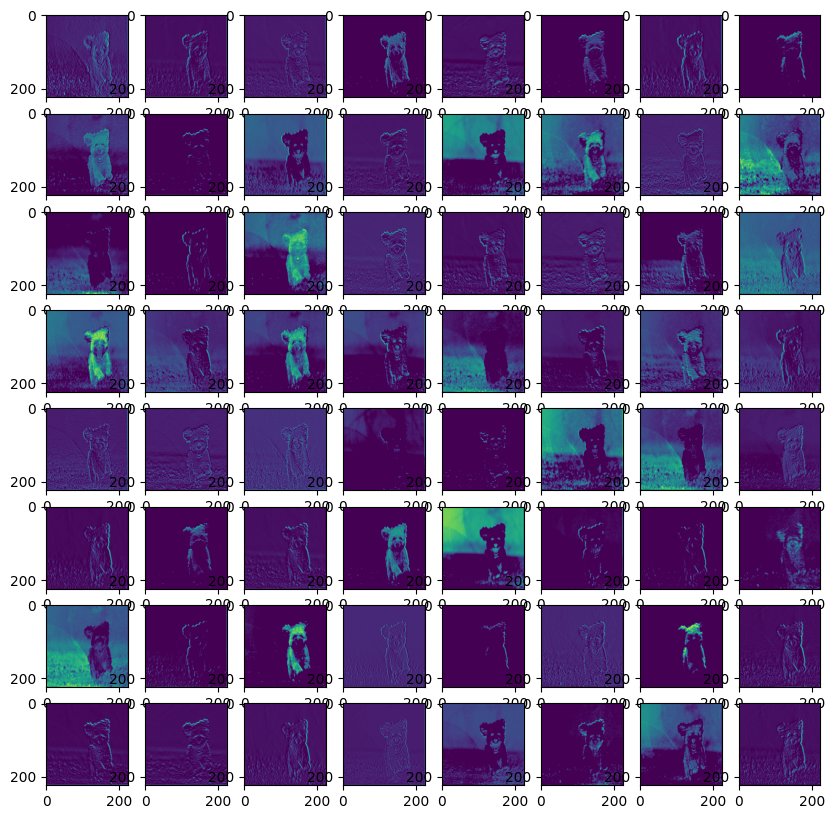

In [16]:
me = Image.open('dog.jpg')
vgg16.eval()
img = me
img = img.resize((224, 224), Image.BILINEAR)

img = np.array(img, dtype=np.float32)[:, :, 0:3] / 255
img = img.transpose((2, 0, 1))
# transform into a batch containing one image
img = np.expand_dims(img, 0)
x = torch.Tensor(img)

t = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

# Visualize feature maps
activation = {}

vgg16.features[0].register_forward_hook(get_activation('conv0'))
vgg16.features[1].register_forward_hook(get_activation('ReLU1'))
vgg16.features[2].register_forward_hook(get_activation('conv2'))
vgg16.features[3].register_forward_hook(get_activation('ReLU3'))
vgg16.features[4].register_forward_hook(get_activation('maxpool4'))
vgg16.features[28].register_forward_hook(get_activation('conv28'))

y = vgg16(t(x))

show_grid(activation['conv0'][0], x_len=8, y_len=8)

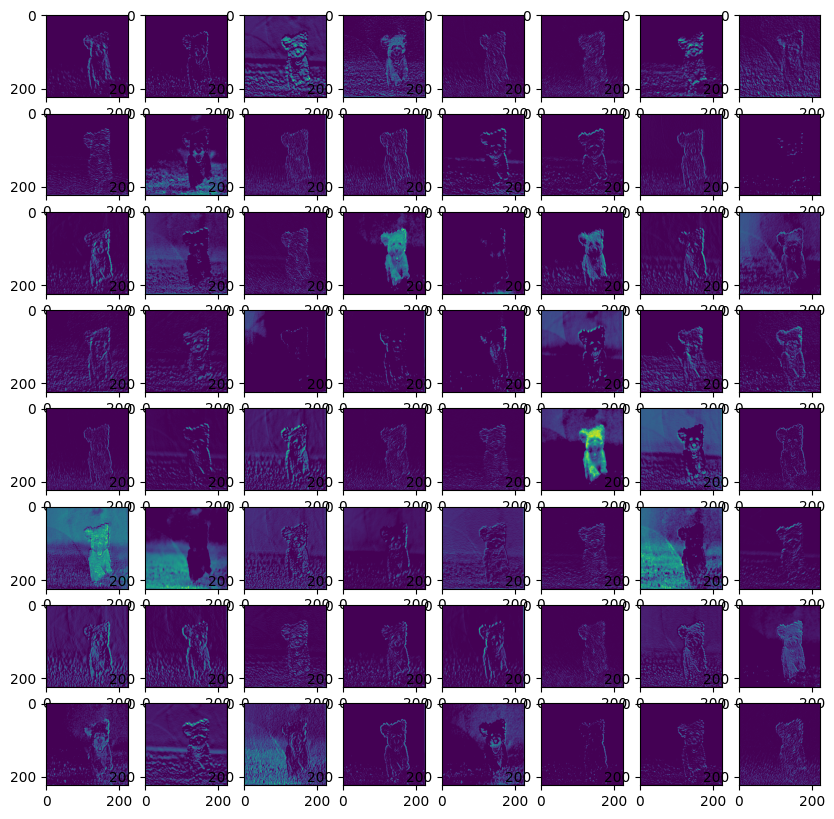

In [18]:
show_grid(activation['conv2'][0], x_len=8, y_len=8)

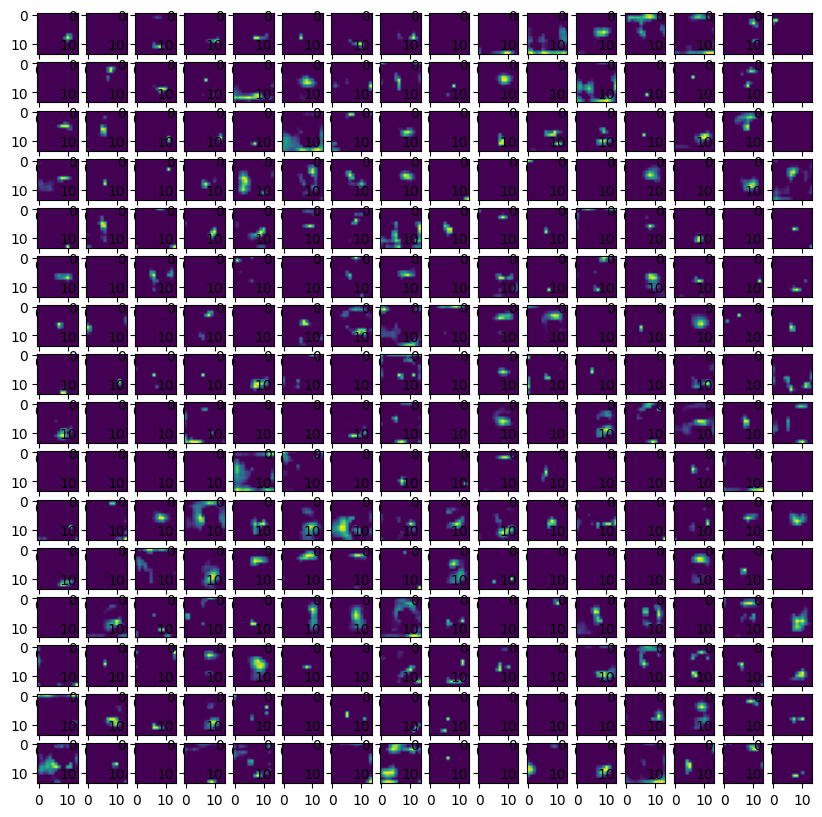

In [22]:
show_grid(activation['conv28'][0:256][0], x_len=16, y_len=16)

In [28]:
a = imagenet_classes.values()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!unzip 15ScenesData.zip

In [2]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0042.jpg  image_0082.jpg  image_0124.jpg  image_0170.jpg
image_0004.jpg  image_0043.jpg  image_0084.jpg  image_0128.jpg  image_0175.jpg
image_0006.jpg  image_0047.jpg  image_0086.jpg  image_0130.jpg  image_0176.jpg
image_0007.jpg  image_0049.jpg  image_0087.jpg  image_0131.jpg  image_0180.jpg
image_0008.jpg  image_0050.jpg  image_0088.jpg  image_0134.jpg  image_0182.jpg
image_0011.jpg  image_0052.jpg  image_0090.jpg  image_0135.jpg  image_0189.jpg
image_0013.jpg  image_0053.jpg  image_0092.jpg  image_0138.jpg  image_0190.jpg
image_0014.jpg  image_0054.jpg  image_0093.jpg  image_0140.jpg  image_0191.jpg
image_0016.jpg  image_0056.jpg  image_0095.jpg  image_0141.jpg  image_0192.jpg
image_0017.jpg  image_0059.jpg  image_0096.jpg  image_0142.jpg  image_0195.jpg
image_0018.jpg  image_0060.jpg  image_0097.jpg  image_0144.jpg  image_0196.jpg
image_0019.jpg  image_0062.jpg  image_0098.jpg  image_0148.jpg  image_0200.jpg
image_0020.jpg  image_0063.jpg  image_0103.jpg  imag

In [5]:
img = Image.open("15SceneData/test/bedroom/image_0042.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img1 = img.convert('L')
trans = transforms.ToTensor()
img2 = trans(img1)

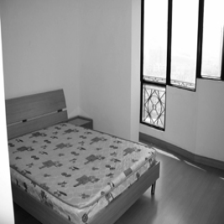

In [6]:
img

In [19]:
list(vgg16.classifier.children())[:-2]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True)]

In [10]:
vgg16 = torchvision.models.vgg16(pretrained=True)

class VGG16relu7(nn.Module):
    def __init__(self):
        super(VGG16relu7, self).__init__()
        # Copy the entire convolutional part
        self.features = nn.Sequential(*list(vgg16.features.children()))
        # Keep a piece of the classifier: -2 to stop at relu7
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # convoluational to linear
        x = self.classifier(x)
        return x

In [30]:
resnet50 = torchvision.models.resnet50(pretrained=True)

class ResNetrelu7(nn.Module):
    def __init__(self):
        super(ResNetrelu7, self).__init__()
        # Copy the entire convolutional part
        self.features = nn.Sequential(*list(resnet50.children())[:-1])
        # Keep a piece of the classifier: -2 to stop at relu7
        self.classifier =  nn.Sequential(
                              nn.Linear(2048, 2048),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(2048, 2048),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(2048, 4096)
                            )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # convoluational to linear
        x = self.classifier(x)
        return x

In [11]:
list(vgg16.classifier.children())[:-2]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True)]

In [31]:
def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        img = img.resize((224, 224), Image.BILINEAR)
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Lambda(lambda img: duplicateChannel(img)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    n = len(data)
    X = np.empty((0, 4096), dtype=np.float32)
    y = np.empty((0), dtype=np.float32)
    ####################
    ##      FIN        #
    ####################
    index = 0
    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire
        X = np.concatenate((X, model(input).detach().cpu().numpy()), axis=0)
        y = np.concatenate((y, np.array(target, dtype=np.float32)))
        ####################
        ##      FIN        #
        ####################    
    return X, y

In [41]:
PRINT_INTERVAL = 50
CUDA = True


batch_size = 8
path = './15SceneData'
# print('Instanciation de VGG16')

#####################
## Votre code ici  ##
#####################
# Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
# On créera une nouvelle classe VGG16relu7 ici
# model = ResNetrelu7()
model = VGG16relu7()
####################
##      FIN        #
####################      

In [42]:
model.eval()
if CUDA: # si on fait du GPU, passage en CUDA
    cudnn.benchmark = True
    model = model.cuda()

# On récupère les données
print('Récupération des données')
train, test = get_dataset(batch_size, path)

# Extraction des features
print('Feature extraction')
X_train, y_train = extract_features(train, model)
X_test, y_test = extract_features(test, model)


Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


In [43]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import timeit
from torch.utils.tensorboard import SummaryWriter

In [44]:

#####################
## Votre code ici  ##
#####################
# Apprentissage et évaluation des SVM à faire
print('Apprentissage des SVM')
start = timeit.default_timer()
accuracy = 0
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)
stop = timeit.default_timer()
print(f'Train time：{stop - start}')

start = timeit.default_timer()
accuracy = clf.score(X_test, y_test)
stop = timeit.default_timer()
print(f'Test time：{stop - start}')
####################
##      FIN        #
####################    
print('Accuracy = %f' % accuracy)

Apprentissage des SVM
Train time：184.92653601500024
Test time：0.10871751900049276
Accuracy = 0.864992


/home/yunfei/anaconda3/envs/sorbonne/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [38]:
X_train.shape

(1500, 4096)

In [39]:
X_test.shape

(2985, 4096)

In [98]:
C_values = [0.01, 0.1, 1]


def hyper_parameters_selection():
    writer = SummaryWriter("SVM_hyper_parameters")
    for c in C_values:
        print(f'Training SVM with  C={c}')
        # TODO
        clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5, C=c))
        # Fit on sub-train set
        # TODO
        start = timeit.default_timer()
        clf.fit(X_train, y_train)
        stop = timeit.default_timer()
        print(f'Train time：{stop - start}')
        
        # Evaluate on val set
        start = timeit.default_timer()
        score = clf.score(X_test, y_test)
        stop = timeit.default_timer()
        print(f'Test time：{stop - start}')
        # TODO

        writer.add_hparams({'C': c},
                           {'accuracy': score})
    writer.close()
hyper_parameters_selection()

Training SVM with  C=0.01
Train time：-143.84451453200018
Test time：-0.09185460099979537
Training SVM with  C=0.1


/home/yunfei/anaconda3/envs/AMAL/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train time：-195.7468469029991
Test time：-0.10556254999937664
Training SVM with  C=1
Train time：-195.8847903599999
Test time：-0.09615143999872089


/home/yunfei/anaconda3/envs/AMAL/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Train with nn

In [68]:
vgg16 = torchvision.models.vgg16(pretrained=True)

class VGG16NN(nn.Module):
    def __init__(self):
        super(VGG16NN, self).__init__()
        # Copy the entire convolutional part
        self.features = nn.Sequential(*list(vgg16.features.children()))
        for param in self.features.parameters():
            param.requires_grad = False
        # Keep a piece of the classifier: -2 to stop at relu7
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2], nn.Linear(4096, 15))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # convoluational to linear
        x = self.classifier(x)
        return x

In [69]:
def train(epoch, data_train, model, loss_fun, optimizer, writer):
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    iter = epoch*len(data_train)
    model.train()
    for batch, target in data_train:
        batch = batch.to(device)  # swap the first and second dimension, make it T, B, d
        target = target.to(device)
        prediction = model(batch)
        loss = loss_fun(prediction, target)
        acc = accuracy(prediction, target)
        loss_meter.update(loss)
        acc_meter.update(acc)
        # print("Epoch: {}; Iteration: {}; Loss: {}, Accuracy: {}".format(epoch, iter, loss, acc))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iter += 1
        writer.add_scalar("Train/Loss", loss, iter)
        writer.add_scalar("Train/Accuracy", acc, iter)
    writer.add_scalar("Train/Epoch Loss", loss_meter.avg, epoch)
    writer.add_scalar("Train/Epoch Accuracy", acc_meter.avg, epoch)


def evaluate(epoch, data_test, model, loss_fun, writer):
    model.eval()
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    iter = epoch*len(data_test)
    for batch, target in data_test:
        batch = batch.to(device)  # swap the first and second dimension, make it T, B, d
        target = target.to(device)
        prediction = model(batch)
        loss = loss_fun(prediction, target)
        acc = accuracy(prediction, target)
        loss_meter.update(loss)
        acc_meter.update(acc)
        iter += 1
        # print("Epoch: {}; Iteration: {}; Loss: {}, Accuracy: {}".format(epoch, iter, loss, acc))
        writer.add_scalar("Test/Loss", loss, iter)
        writer.add_scalar("Test/Accuracy", acc, iter)
    writer.add_scalar("Test/Epoch Loss", loss_meter.avg, epoch)
    writer.add_scalar("Test/Epoch Accuracy", acc_meter.avg, epoch)


def accuracy(prediction, target):
    prediction = torch.argmax(prediction, dim=1)
    return torch.mean((prediction == target).float())

In [70]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, keep_all=False):
        self.reset()
        self.data = None
        if keep_all:
            self.data = []

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.data is not None:
            self.data.append(val)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [71]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"./transfer_learning")
device = 'cuda'
model = VGG16NN()
model = model.to(device)
optimizer = torch.optim.SGD(model.classifier.parameters(), 0.01)
loss_fun = torch.nn.CrossEntropyLoss()
data_train, data_test = get_dataset(batch_size, path)
for epoch in tqdm(range(50)):
    train(epoch, data_train, model, loss_fun, optimizer, writer)
    evaluate(epoch, data_test, model, loss_fun, writer)

    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [14:39<00:00, 17.59s/it]


In [60]:
for i, j in data_train:
    break

In [61]:
i.size()

torch.Size([8, 3, 224, 224])

In [ ]:
def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = vgg16 
    ####################
    ##      FIN        #
    ####################      
    
    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    ####################
    ##      FIN        #
    ####################    
    print('Accuracy = %f' % accuracy)


In [ ]:
main("15SceneData", 8)

In [16]:
from sklearn.preprocessing import StandardScaler
data = [[0, 0], [0, 0], [1, 1], [1, 1], [3, 3]]
scaler = StandardScaler()
scaler.fit(data)
scaler.mean_

array([1., 1.])

In [17]:
scaler.var_

array([1.2, 1.2])

In [18]:
scaler.transform(data)

array([[-0.91287093, -0.91287093],
       [-0.91287093, -0.91287093],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 1.82574186,  1.82574186]])